# Machine translation

I made this project to get more familiar with NLP and learn something about Machine translation, as well as practice working with torch and torchtext. The ultimate goal was to create a machine translation pipeline, going from raw data to trained algorithm, and adjust it according to currently used data / architecture. This notebook puts all the modules together.

I won't present all the code here. For anyone curious, I encourage you to check out the source code. Set up GPU is assumed.

### Prerequisities

##### Datasets

WMT14
- download https://1drv.ms/f/s!AiQ5a2cXVytTlkZD0HQn5FdGRgB2
- move to data/WMT14

Multi30k
- download https://1drv.ms/f/s!AiQ5a2cXVytTllU4usk93QbPGv1s
- move to data/Multi30k

##### Environment

I highly recommend setting up a conda environment before installing packages.
- navigate to root
- pip install -r requirements.txt

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

from src.data.loader import load_multi30k, load_WMT14
from src.data.raw_to_proc import proc_WMT14, proc_multi30k, create_WMT14_samp
from src.models.lstm_rnn import SimpleEncoder,SimpleEncoderVLS,SimpleDecoder
from src.models.RNN_search import AttnEncoder, AttnDecoder
from src.models import fit,translate

import torch
import torch.nn.functional as F
import torch.optim as optim

d:\programs\anaconda3\envs\machine_translation\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
d:\programs\anaconda3\envs\machine_translation\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
d:\programs\anaconda3\envs\machine_translation\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
d:\programs\anaconda3\envs\machine_translation\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


### Data preprocessing

##### Restructuring

Although the downloads provide both raw and processed datasets, I would like to share functions used on raw data to create the processed data.

In [ ]:
proc_multi30k()
proc_WMT14()
create_WMT14_samp()

##### Accessing data

These functions are used to get access to 3 dataset loaders - WMT14 with batch size 1, Multi30k with batch size 1 and Multi30k with custom batch size (I chose 32). My implementation doesn't support other batch sizes for WMT14. The two variants of Multi30k will be used to showcase certain features of batching when using RNNs.

WMT14 dataset is czech-english, Multi30k is german-english. We are going to translate to english in both cases, hence TRG corresponds to english vocab and SRC corresponds to either czech or german vocab.

In [2]:
train_iter, valid_iter, SRC, TRG = load_WMT14(1)
src, trg = 'src','trg'
ds_name = 'WMT14'

In [2]:
train_iter, valid_iter, SRC, TRG = load_multi30k(1)
src, trg = 'de','en'
ds_name = 'Multi30k'

In [2]:
train_iter, valid_iter, SRC, TRG = load_multi30k(32)
src, trg = 'de','en'
ds_name = 'Multi30k'

Let's set some useful variables too.

In [3]:
n_words_src = len(SRC.vocab)
n_words_trg = len(TRG.vocab)

In [4]:
pad_src_id = SRC.vocab.stoi['<pad>']
pad_trg_id = TRG.vocab.stoi['<pad>']

In [5]:
trg_sos_id = TRG.vocab.stoi['<SOS>']
trg_eos_id = TRG.vocab.stoi['<EOS>']
src_eos_id = SRC.vocab.stoi['<EOS>']

In [6]:
train_len = len(train_iter)
val_len = len(valid_iter)

### Models

##### LSTM RNN

In [7]:
model_name = 'LSTM_RNN'

Setting some basic parameters for network - sizes of embedding vectors and hidden layers.

In [8]:
embedding_size_src = 300
embedding_size_trg = 300

In [9]:
n_hidden_src = 200
n_hidden_trg = 200

This is the most basic type of model we will use. For practical reasons, we are going to treat encoder and decoder separately. The pair below is only capable of single-sequence input processing.

In [10]:
enc = SimpleEncoder(n_words_src,embedding_size_src,n_hidden_src).cuda()
dec = SimpleDecoder(n_words_trg,embedding_size_trg,n_hidden_trg).cuda()

The pair below is able to work with batch of VLS (variable length sequences). Because we are working with RNNs, parallel computation isn't as straightforward as in the case of other architectures, especially in our case with big amount of short sequences of variable lengths. The real dealbreaker here is the fact that we have pairs of sequences, meaning we can't simply join together the ones with least padding. As a solution, I have tried to implement PyTorch PackedSequence objects, with at least some succes. 

In [25]:
enc = SimpleEncoderVLS(n_words_src,embedding_size_src,n_hidden_src,pad_src_id).cuda()
dec = SimpleDecoder(n_words_trg,embedding_size_trg,n_hidden_trg).cuda()

The hyperparameters used can be changed as needed.

##### RNNsearch

In [7]:
model_name = 'RNNsearch'

Here we also need to set some additional parameters - number of layers in encoder / decoder and number of hidden units in alignment network.

In [8]:
embedding_size_src = 150
embedding_size_trg = 150

In [9]:
n_hidden_src = 100
n_hidden_trg = 100

In [10]:
n_layers_src = 1
n_layers_trg = 1

In [11]:
n_allign = 120

In [12]:
bidirectional = True
n_dir_enc = 1 if not bidirectional else 2

In [13]:
n_l = 100

In this case, I wasn't able (yet) to come up with a solution for parallel computation of batches of data, so here I only provide model capable of using only one example at a time.

In [14]:
enc = AttnEncoder(n_words_src,embedding_size_src,n_hidden_src,n_layers_src,bidirectional=True).cuda()
dec = AttnDecoder(n_words_trg,embedding_size_trg,n_hidden_trg,n_hidden_src,n_dir_enc,n_allign,
                  n_layers_trg, n_l).cuda()

The hyperparameters used can be changed as needed.

### Training 

##### LSTM RNN

Setting up some training parameters - optimizers, learning rate, loss function, number of epochs

In [11]:
opt_enc = optim.SGD(enc.parameters(),5e-2)
opt_dec = optim.SGD(dec.parameters(),5e-2)
loss_fn = F.nll_loss
epochs = 1

This set of functions should be used for non-VLS model. As can be seen, manual teacher forcing scheduling is done in this case. In order to manipulate length of training you can change the end_train and end_val parameters. I suggest using print_every size 5 times smaller than end_train.

In [12]:
end_train = int(train_len/2.5)
end_val = int(val_len/10)
print_every = int(train_len/(2.5*5))
teacher_forcing = 0.8

In [13]:
fit.lstm_rnn(enc,dec,train_iter,valid_iter,epochs,opt_enc,opt_dec,loss_fn,n_words_trg, trg_sos_id,
             src, trg, ds_name, model_name, end_train=end_train,end_val=end_val, print_every=print_every,
             teacher_forcing=teacher_forcing)

10.0% done
20.0% done
Train: 5.327145569395311 
Valid: 5.563345795810813 

30.0% done
40.0% done
Train: 5.550377472792522 
Valid: 5.714892082875318 

50.0% done
60.0% done
Train: 5.416947412018729 
Valid: 5.4183317411063925 

70.0% done
80.0% done
Train: 5.654766875918549 
Valid: 5.420583524326287 

90.0% done
100.0% done
Train: 5.32790996768687 
Valid: 5.306070632273608 



In [14]:
teacher_forcing = 0.6

In [15]:
fit.lstm_rnn(enc,dec,train_iter,valid_iter,epochs,opt_enc,opt_dec,loss_fn,n_words_trg, trg_sos_id,
             src, trg, ds_name, model_name, end_train=end_train,end_val=end_val, print_every=print_every,
             teacher_forcing=teacher_forcing)

10.0% done
20.0% done
Train: 5.296095087976739 
Valid: 5.3311643576858065 

30.0% done
40.0% done
Train: 5.261613472853557 
Valid: 5.460841544783942 

50.0% done
60.0% done
Train: 5.209893132200335 
Valid: 5.042675308661885 

70.0% done
80.0% done
Train: 5.332276157813497 
Valid: 5.122009570055669 

90.0% done
100.0% done
Train: 4.821227283761052 
Valid: 5.023271447361106 



In [16]:
teacher_forcing = 0.4

In [17]:
fit.lstm_rnn(enc,dec,train_iter,valid_iter,epochs,opt_enc,opt_dec,loss_fn,n_words_trg, trg_sos_id,
             src, trg, ds_name, model_name, end_train=end_train,end_val=end_val, print_every=print_every,
             teacher_forcing=teacher_forcing)

10.0% done
20.0% done
Train: 4.9411532430365535 
Valid: 4.925353555396052 

30.0% done
40.0% done
Train: 4.7104212340742055 
Valid: 4.890491973055472 

50.0% done
60.0% done
Train: 4.850762142993436 
Valid: 4.938945999239931 

70.0% done
80.0% done
Train: 4.640170205937753 
Valid: 4.881005641257409 

90.0% done
100.0% done
Train: 4.8010581436723765 
Valid: 4.621567053369956 



In [18]:
teacher_forcing = 0.2

In [19]:
fit.lstm_rnn(enc,dec,train_iter,valid_iter,epochs,opt_enc,opt_dec,loss_fn,n_words_trg, trg_sos_id,
             src, trg, ds_name, model_name, end_train=end_train,end_val=end_val, print_every=print_every,
             teacher_forcing=teacher_forcing)

10.0% done
20.0% done
Train: 4.721157050368809 
Valid: 4.836243132553478 

30.0% done
40.0% done
Train: 4.546585805345289 
Valid: 4.470274732844664 

50.0% done
60.0% done
Train: 4.73297922918112 
Valid: 4.3828479700749465 

70.0% done
80.0% done
Train: 4.458686957264891 
Valid: 4.507400437156753 

90.0% done
100.0% done
Train: 4.432864297734628 
Valid: 4.328211118679236 



In [20]:
teacher_forcing = 0

In [21]:
fit.lstm_rnn(enc,dec,train_iter,valid_iter,epochs,opt_enc,opt_dec,loss_fn,n_words_trg, trg_sos_id,
             src, trg, ds_name, model_name, end_train=end_train,end_val=end_val, print_every=print_every,
             teacher_forcing=teacher_forcing)

10.0% done
20.0% done
Train: 4.70091197986414 
Valid: 4.381637991064846 

30.0% done
40.0% done
Train: 4.550082047386925 
Valid: 4.432566142318272 

50.0% done
60.0% done
Train: 4.698509504299353 
Valid: 4.33996042638722 

70.0% done
80.0% done
Train: 4.309729004850482 
Valid: 4.338711856615426 

90.0% done
100.0% done
Train: 4.444754198046014 
Valid: 4.467905854234601 



This function should be used to train the VLS model.

In [21]:
fit.lstm_rnn_vls(enc,dec,train_iter,valid_iter,epochs,opt_enc,opt_dec,loss_fn,n_words_trg, trg_sos_id,
                 pad_src_id, pad_trg_id,end_train=int(train_len/5),end_val=int(val_len/5),
                 print_every=int(train_len/(5*5)))

0.6% done
1.1% done
1.7% done
2.2% done
2.8% done
3.3% done
3.9% done
4.4% done
5.0% done
5.5% done
6.1% done
6.6% done
7.2% done
7.7% done
8.3% done
8.8% done
9.4% done
9.9% done
10.5% done
11.0% done
11.6% done
12.2% done
12.7% done
13.3% done
13.8% done
14.4% done
14.9% done
15.5% done
16.0% done
16.6% done
17.1% done
17.7% done
18.2% done
18.8% done
19.3% done
19.9% done
Train: 5.073108215524693 
Valid: 5.1813329735187565 

20.4% done
21.0% done
21.5% done
22.1% done
22.7% done
23.2% done
23.8% done
24.3% done
24.9% done
25.4% done
26.0% done
26.5% done
27.1% done
27.6% done
28.2% done
28.7% done
29.3% done
29.8% done
30.4% done
30.9% done
31.5% done
32.0% done
32.6% done
33.1% done
33.7% done
34.3% done
34.8% done
35.4% done
35.9% done
36.5% done
37.0% done
37.6% done
38.1% done
38.7% done
39.2% done
39.8% done
Train: 5.2609340686990755 
Valid: 5.150072846749817 

40.3% done
40.9% done
41.4% done
42.0% done
42.5% done
43.1% done
43.6% done
44.2% done
44.8% done
45.3% done
45.9% do

Fit functions automatically save progress along with printing losses (see source code of fit functions), but these functions can be used to manually save / load models.

In [22]:
model_path_Multi30k = 'models/LSTM_RNN/Multi30k/'
model_path_WMT14 = 'models/LSTM_RNN/WMT14/'

Loading / saving Multi30k models

In [18]:
enc.load_state_dict(torch.load(f'{model_path_Multi30k}enc.pt'))
dec.load_state_dict(torch.load(f'{model_path_Multi30k}dec.pt'))

In [23]:
torch.save(enc.state_dict(), f'{model_path_Multi30k}enc.pt')
torch.save(dec.state_dict(), f'{model_path_Multi30k}dec.pt')

Loading / saving WMT14 models

In [18]:
enc.load_state_dict(torch.load(f'{model_path_WMT14}enc.pt'))
dec.load_state_dict(torch.load(f'{model_path_WMT14}dec.pt'))

In [17]:
torch.save(enc.state_dict(), f'{model_path_WMT14}enc.pt')
torch.save(dec.state_dict(), f'{model_path_WMT14}dec.pt')

Example of loading 3rd iteration of Multi30k model.

In [15]:
enc.load_state_dict(torch.load(f'{model_path_Multi30k}enc_3.pt'))
dec.load_state_dict(torch.load(f'{model_path_Multi30k}dec_3.pt'))

##### RNNsearch

Setting up some training parameters - optimizers, learning rate, loss function, number of epochs

In [49]:
opt_enc = optim.Adadelta(enc.parameters())
opt_dec = optim.Adadelta(dec.parameters())
loss_fn = F.nll_loss
epochs = 1

These parameters serve for selecting an amount of data to go through each epoch (it's convenient to use fractions of original length). Some additional parameters can also be found - number of (moving) losses to plot and saving frequency. Role of batch size and teacher forcing should be obvious (attention - the batch size here refers to number of gradients computed before updating weights, not parallel computation).

In [50]:
end_train = int(train_len/10)
end_val = int(val_len/20)
plot_every = int(train_len/(10*30))
save_every = int(train_len/(10*3))
batch_size = 8
teacher_forcing = 0.8


Train: 4.937930927276612 
Valid: 4.78165462732315


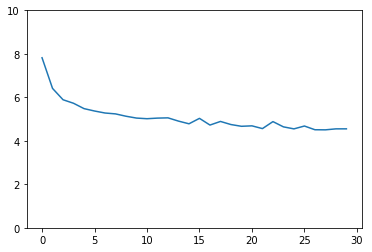

In [51]:
fit.rnnsearch(enc, dec, train_iter, valid_iter, epochs, opt_enc, opt_dec, loss_fn, n_words_trg, 
              teacher_forcing, end_train, end_val, plot_every, save_every, batch_size)

In [52]:
teacher_forcing = 0.6


Train: 4.526327800750733 
Valid: 4.388412564992905


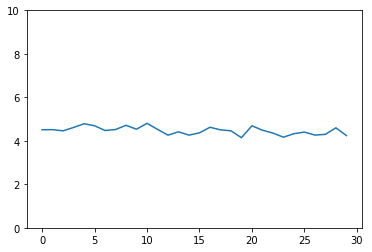

In [53]:
fit.rnnsearch(enc, dec, train_iter, valid_iter, epochs, opt_enc, opt_dec, loss_fn, n_words_trg, 
              teacher_forcing, end_train, end_val, plot_every, save_every, batch_size)

In [54]:
teacher_forcing = 0.4


Train: 4.363866720199585 
Valid: 4.385010566711426


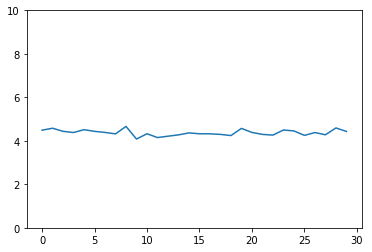

In [55]:
fit.rnnsearch(enc, dec, train_iter, valid_iter, epochs, opt_enc, opt_dec, loss_fn, n_words_trg, 
              teacher_forcing, end_train, end_val, plot_every, save_every, batch_size)

In [56]:
teacher_forcing = 0.2


Train: 4.328554701805115 
Valid: 4.471458904743194


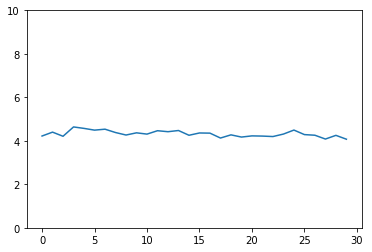

In [57]:
fit.rnnsearch(enc, dec, train_iter, valid_iter, epochs, opt_enc, opt_dec, loss_fn, n_words_trg, 
              teacher_forcing, end_train, end_val, plot_every, save_every, batch_size)

In [58]:
teacher_forcing = 0


Train: 4.235197310447693 
Valid: 4.116661834716797


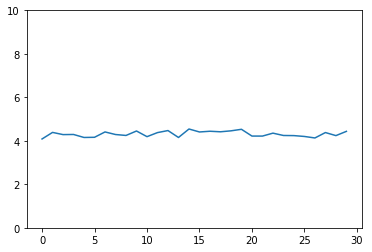

In [59]:
fit.rnnsearch(enc, dec, train_iter, valid_iter, epochs, opt_enc, opt_dec, loss_fn, n_words_trg, 
              teacher_forcing, end_train, end_val, plot_every, save_every, batch_size)

Loading trained models

In [15]:
model_path_Multi30k = 'models/RNNsearch/Multi30k/'
model_path_WMT14 = 'models/RNNsearch/WMT14/'

Loading / saving Multi30k models

(currently there is incompatible version of model in models folder, so this won't work)

In [16]:
enc.load_state_dict(torch.load(f'{model_path_Multi30k}enc.pt'))
dec.load_state_dict(torch.load(f'{model_path_Multi30k}dec.pt'))

In [61]:
torch.save(enc.state_dict(), f'{model_path_Multi30k}enc.pt')
torch.save(dec.state_dict(), f'{model_path_Multi30k}dec.pt')

### Analysis

We won't dig deep into the model's workings / performance. For now, we will only look at examples of the model's translations. This will give us some insight into it's capabilities and we will also be able to better interpret the results given by applying custom metric.

##### LSTM RNN

To get new example, simply reload the line below. 

In [24]:
rand_ex = next(iter(valid_iter))
ex_src,ex_trg = getattr(rand_ex,src),getattr(rand_ex,trg)

These two cells show what we are going to translate and it's human translation.

In [25]:
[SRC.vocab.itos[x] for x in ex_src[:,0]]

['frauen',
 'gehen',
 'durch',
 'den',
 'tiefschnee',
 'einen',
 'steilen',
 'abhang',
 'hinunter',
 '<EOS>']

In [26]:
[TRG.vocab.itos[x] for x in ex_trg[:,0]]

['<SOS>',
 'women',
 'walking',
 'through',
 'deep',
 'snow',
 'and',
 'down',
 'a',
 'steep',
 'hill',
 '<EOS>']

Here we use our model to translate the sentence. Choose appropriate translate function (Multi30k, Multi30k_VLS and WMT14 respectively).

In [28]:
sent_ids = translate.Multi30k(enc,dec,trg_sos_id,trg_eos_id,ex_src)

In [ ]:
sent_ids = translate.Multi30k_VLS(enc,dec,trg_sos_id,trg_eos_id,pad_src_id,ex_src[:,0][:,None])

In [22]:
sent_ids = translate.WMT14(enc,dec,trg_sos_id,trg_eos_id,ex_src)

Now we can take a look at the sentence our model created.

In [29]:
[TRG.vocab.itos[x] for x in sent_ids]

['the', 'woman', 'is', 'through', 'through', 'a', 'field', 'of', '<EOS>']

Definitely not perfect, but some pattern can be seen (better result could be probably obtained by using bigger amount of data).

##### RNNsearch

To get new example, simply reload the line below. 

In [46]:
rand_ex = next(iter(valid_iter))
ex_src,ex_trg = getattr(rand_ex,src),getattr(rand_ex,trg)

These two cells show what we are going to translate and it's human translation.

In [47]:
[SRC.vocab.itos[x] for x in ex_src[:,0]]

['frau',
 'in',
 'einem',
 'weißen',
 'tshirt',
 'und',
 'hosen',
 'entspannt',
 'sich',
 'auf',
 'einem',
 'sofa',
 'in',
 'einem',
 'haus',
 '<EOS>']

In [48]:
[TRG.vocab.itos[x] for x in ex_trg[:,0]]

['<SOS>',
 'woman',
 'with',
 'a',
 'white',
 'shirt',
 'and',
 '<unk>',
 'lounging',
 'on',
 'a',
 'couch',
 'inside',
 'of',
 'a',
 'house',
 '<EOS>']

In [49]:
sent_ids = translate.rnnsearch(enc, dec, trg_sos_id, trg_eos_id, ex_src)

Here is the resulting sequence.

In [50]:
[TRG.vocab.itos[x] for x in sent_ids]

['woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman',
 'woman']

That's pretty bad.

##### Comparison

In [51]:
num = 0
for par in enc.parameters():
    num += len(par)
for par in dec.parameters():
    num += len(par)

In [52]:
num

51245

*LSTM RNN* 
- ~60 000 examples * ~15 words = ~900 000 words
- validation loss = 4.468
- train time ~25 minutes (GeForce GTX 1050 (2GB))
- parameters - 55 203

*RNNsearch* 
- ~15 000 examples * ~15 words = ~225 000 words
- validation loss = 4.12
- train time ~40 minutes (GeForce GTX 1050 (2GB))
- parameters - 51 245

The RNNsearch looks better, but looking to sentence translations above we can see that it performs rather poorly.

### Summary

In this notebook, I introduced two models for neural machine translation, LSTM RNN and RNNsearch. To train them, we used a small dataset focused on narrow field of language (image captions).

Actual translations and loss comparison can be seen in the analysis part. For now, it seems that the LSTM RNN is better in all aspects but loss.